<a href="https://colab.research.google.com/github/Basel112/AutomatedFeedBackGenerator/blob/main/NluProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers datasets accelerate peft bitsandbytes evaluate

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
from datasets import Dataset
import re

# تحميل البيانات
csv_path = '/content/drive/MyDrive/dataset/ASAP2_train_sourcetexts.csv'
df = pd.read_csv(csv_path)

# تنظيف وتحويل الدرجات لتعليقات
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def score_to_comment(score):
    if score >= 4:
        return 'The essay is excellent and demonstrates a deep understanding of the topic.'
    elif score == 3:
        return 'The essay is good but needs minor improvements.'
    elif score == 2:
        return 'The essay is average and needs more clarity in expressing the ideas.'
    else:
        return 'The essay is weak and requires restructuring and better paragraph organization.'

# أخذ عينة صغيرة
df = df.sample(300, random_state=42).reset_index(drop=True)
df['full_text'] = df['full_text'].apply(clean_text)
df['comment'] = df['score'].apply(score_to_comment)
df = df[['full_text', 'comment']].dropna().reset_index(drop=True)

dataset = Dataset.from_pandas(df)


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import torch

model_id = 'tiiuae/falcon-rw-1b'
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.float16
)
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=['query_key_value'],
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.CAUSAL_LM
)
model = get_peft_model(model, lora_config)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

In [5]:
from transformers import TrainingArguments, Trainer

# الترميز
def tokenize(example):
    prompt = f'Essay: {example["full_text"]}\nComment:'
    inputs = tokenizer(prompt, truncation=True, padding='max_length', max_length=64)
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs

tokenized_dataset = dataset.map(tokenize, remove_columns=['full_text', 'comment'])

# إعداد التدريب
training_args = TrainingArguments(
    output_dir='./feedback_model',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    fp16=True,
    learning_rate=2e-4,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

trainer.train()


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<ipython-input-5-4d3db37a9b9b>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,3.330100
20,3.264700
30,3.347100


TrainOutput(global_step=38, training_loss=3.2758954700670744, metrics={'train_runtime': 13.0548, 'train_samples_per_second': 22.98, 'train_steps_per_second': 2.911, 'total_flos': 139412216217600.0, 'train_loss': 3.2758954700670744, 'epoch': 1.0})

In [6]:
save_path = '/content/drive/MyDrive/feedback_model_finetuned'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f'📦 Model saved to {save_path}')


📦 Model saved to /content/drive/MyDrive/feedback_model_finetuned


In [8]:
!pip install rouge_score
from transformers import AutoModelForCausalLM
import evaluate

# تحميل النموذج الأصلي
original_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map='auto'
)
original_tokenizer = AutoTokenizer.from_pretrained(model_id)
original_tokenizer.pad_token = original_tokenizer.eos_token

# تحميل النموذج المدرب
finetuned_model = AutoModelForCausalLM.from_pretrained(
    save_path,
    torch_dtype=torch.float16,
    device_map='auto'
)
finetuned_tokenizer = AutoTokenizer.from_pretrained(save_path)

# عينات للتقييم
sample = df.sample(10, random_state=1)
prompts = [f"Essay: {text}\nComment:" for text in sample["full_text"]]
references = list(sample["comment"])

rouge = evaluate.load("rouge")

def generate_comments(model, tokenizer, prompts):
    outputs = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs_ids = model.generate(**inputs, max_new_tokens=30)
        generated = tokenizer.decode(outputs_ids[0], skip_special_tokens=True)
        comment = generated.split("Comment:")[-1].strip()
        outputs.append(comment)
    return outputs

print("🔍 Evaluating original model...")
original_preds = generate_comments(original_model, original_tokenizer, prompts)
original_scores = rouge.compute(predictions=original_preds, references=references)

print("🔍 Evaluating fine-tuned model...")
finetuned_preds = generate_comments(finetuned_model, finetuned_tokenizer, prompts)
finetuned_scores = rouge.compute(predictions=finetuned_preds, references=references)

print("📊 ROUGE Scores:")
print("Original:", original_scores)
print("Fine-tuned:", finetuned_scores)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1d5710917acb196e91796c61725c54aadf2e234189b8d988cc487fab7d313c9b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🔍 Evaluating original model...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🔍 Evaluating fine-tuned model...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


📊 ROUGE Scores:
Original: {'rouge1': np.float64(0.16826262333681347), 'rouge2': np.float64(0.010526315789473684), 'rougeL': np.float64(0.15673766497428054), 'rougeLsum': np.float64(0.15787553475633972)}
Fine-tuned: {'rouge1': np.float64(0.12677729927729928), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.12068755568755567), 'rougeLsum': np.float64(0.12322616572616571)}


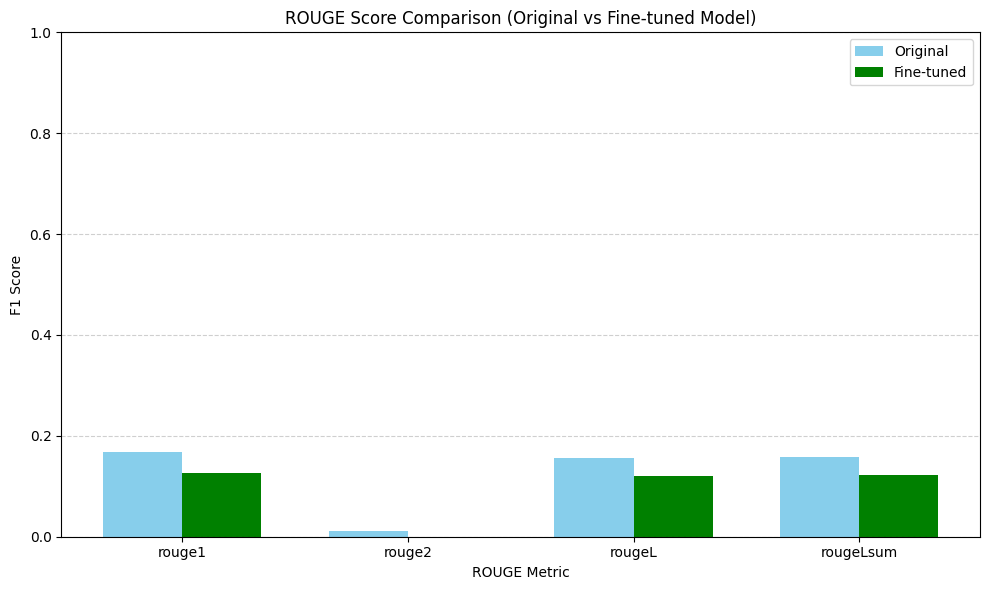

In [10]:
import matplotlib.pyplot as plt

# ROUGE metrics
metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

# Extract values correctly (they are already float scalars)
original_vals = [original_scores[m] for m in metrics]
finetuned_vals = [finetuned_scores[m] for m in metrics]

x = range(len(metrics))
width = 0.35

# Plotting
plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], original_vals, width=width, label='Original', color='skyblue')
plt.bar([i + width/2 for i in x], finetuned_vals, width=width, label='Fine-tuned', color='green')

plt.xlabel('ROUGE Metric')
plt.ylabel('F1 Score')
plt.title('ROUGE Score Comparison (Original vs Fine-tuned Model)')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Device set to use cpu


📝 Generating comments and evaluating...



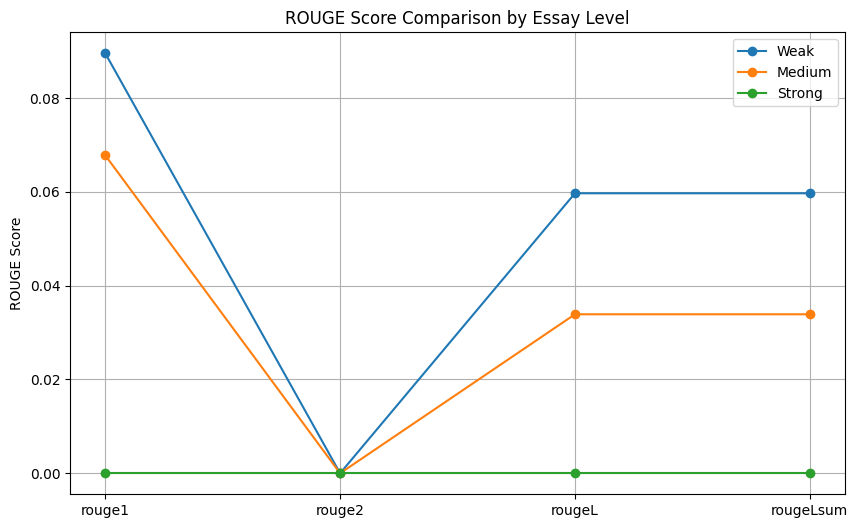


--- Weak Essay ---
Generated Comment:
I think that the article is very interesting and I think that it is a good idea to write about pollution because it is a very important topic that needs to be discussed and I think that it is a good idea to write about it because it is a
Reference Comment:
Try to avoid repeating the same ideas. Your essay lacks structure and clear support for your opinion.

--- Medium Essay ---
Generated Comment:
Pollution is a major problem in our world today. It is a problem that affects many aspects of our lives, including our health and the environment. Pollution is a problem that is not going away anytime soon. It is a problem that is not
Reference Comment:
Your essay introduces the topic well but could benefit from more specific examples and organization.

--- Strong Essay ---
Generated Comment:
I think that climate change is a serious problem that needs to be addressed by the world. The world is in a serious crisis because of climate change. The world is in

In [13]:
from transformers import pipeline
import evaluate
import matplotlib.pyplot as plt


essays = {
    "Weak": "I think that the article is very interesting and I think that it is a good idea to write about pollution because it is a very important topic that needs to be discussed and I think that it is a good idea to write about it because it is a",
    "Medium": "Pollution affects many aspects of our lives, including our health and the environment. This essay will discuss the causes of pollution and suggest some ways to reduce its impact.",
    "Strong": "Climate change and pollution are among the most urgent challenges of our time. Governments, industries, and individuals must collaborate to implement sustainable solutions such as renewable energy, reducing emissions, and raising awareness. By taking action now, we can secure a healthier future for generations to come."
}


references = {
    "Weak": "Try to avoid repeating the same ideas. Your essay lacks structure and clear support for your opinion.",
    "Medium": "Your essay introduces the topic well but could benefit from more specific examples and organization.",
    "Strong": "Excellent structure and vocabulary. Your essay presents clear arguments with good supporting details."
}


generator = pipeline("text-generation", model=finetuned_model, tokenizer=finetuned_tokenizer)
rouge = evaluate.load("rouge")

print("📝 Generating comments and evaluating...\n")

generated_comments = {}
rouge_results = {}

for level, text in essays.items():
    prompt = f"Essay: {text}\nComment:"
    generated = generator(prompt, max_new_tokens=50, do_sample=False)[0]['generated_text']
    comment = generated.split("Comment:")[-1].strip()
    generated_comments[level] = comment

    score = rouge.compute(predictions=[comment], references=[references[level]])
    rouge_results[level] = score


metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

plt.figure(figsize=(10, 6))
for level in essays.keys():
    values = [rouge_results[level][m] for m in metrics]
    plt.plot(metrics, values, marker='o', label=level)

plt.title("ROUGE Score Comparison by Essay Level")
plt.ylabel("ROUGE Score")
plt.legend()
plt.grid(True)
plt.show()


for level in essays:
    print(f"\n--- {level} Essay ---")
    print(f"Generated Comment:\n{generated_comments[level]}")
    print(f"Reference Comment:\n{references[level]}")


In [12]:
!pip install -q gradio

import gradio as gr
from transformers import pipeline

# استخدام Pipeline للتوليد بدون تحديد device
generator = pipeline("text-generation", model=finetuned_model, tokenizer=finetuned_tokenizer)

def generate_feedback(essay):
    prompt = f"Essay: {essay}\nComment:"
    result = generator(prompt, max_new_tokens=50, do_sample=False)[0]['generated_text']
    comment = result.split("Comment:")[-1].strip()
    return comment

# واجهة Gradio
with gr.Blocks() as demo:
    gr.Markdown("## 📝 Automated Essay Feedback Generator")
    essay_input = gr.Textbox(lines=10, label="✍️ Enter your essay here")
    output_comment = gr.Textbox(lines=3, label="🗣️ Generated Feedback")
    btn = gr.Button("Generate Feedback")
    btn.click(generate_feedback, inputs=essay_input, outputs=output_comment)

demo.launch(share=True)


Device set to use cpu


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://daed7ebf24382f4ce1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
